In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,  "/project/remote/pento-diaref")

In [2]:
import os
from matplotlib import pyplot as plt

In [3]:
results_dir = "../original_results"

In [5]:
from pentodiaref.data.generation.types import Annotation

def annos_by_global_id(data_dir, stage_name):
    data_categories = ["ho-pos", "ho-color", "ho-uts", "data"]
    by_gid = {}
    for category in data_categories:
        data_name = category + "_" + stage_name
        for anno in Annotation.load(data_dir, data_name, resolve=False):
            by_gid[anno["global_id"]] = anno
    return by_gid

annos_by_gid = annos_by_global_id("/data/pento_diaref/didact", "test")

Loaded 840 from /data/pento_diaref/didact/ho-pos_test.json
Loaded 756 from /data/pento_diaref/didact/ho-color_test.json
Loaded 840 from /data/pento_diaref/didact/ho-uts_test.json
Loaded 10000 from /data/pento_diaref/didact/data_test.json


In [12]:
import pandas as pd
import seaborn as sns
import re
import json
from golmi.contrib.pentomino.symbolic.types import Shapes, Colors, RelPositions
from pentodiaref.data.generation.expressions import utterance_types_csp

In [7]:
class UTParser():
    
    def __init__(self):
        colors =  [c.value_name.lower() for c in list(Colors)]
        shapes = [s._value_.lower() for s in list(Shapes)]
        colors_str = "|".join([c for c in colors])
        shapes_str = "|".join([s for s in shapes])
        # align idx numbers with plits from the paper
        UT2 = 2, f"take the ({colors_str}) piece in" # "piece" is matched by shape "p" ...
        UT0 = 1, f"take the ({colors_str}) piece"
        UT3 = 4, f"take the ({colors_str}) ({shapes_str}) in"
        UT1 = 3, f"take the ({colors_str}) ({shapes_str})"
        UT6 = 6, f"take the piece in"
        UT5 = 5, f"take the ({shapes_str}) in"
        UT4 = 0, f"take the ({shapes_str})"
        self.uts = [UT2,UT0,UT3,UT1,UT6,UT5,UT4]
    
    def parse(self, sent):
        sent = sent.lower()
        for idx, ut in self.uts:
            if re.search(ut, sent):
                return idx
        return 7 # no matches
        
parser = UTParser()
assert parser.parse("Take the blue piece") == 1
assert parser.parse("Take the blue T") == 3
assert parser.parse("Take the blue piece in the center") == 2
assert parser.parse("Take the blue T in the center") == 4
assert parser.parse("Take the T") == 0
assert parser.parse("Take the T in the center") == 5
assert parser.parse("Take the piece in the center") == 6

In [14]:
def create_model_hists_df(pred_files, category, ignore_unk=False):
    records = []
    for pred_file in pred_files:
        model_name = "none"
        if "lstm" in pred_file:
            model_name = "LSTM"
        if "transformer" in pred_file:
            model_name = "Transf."
        if "classifier" in pred_file:
            model_name = "Classifier"
        if "vse" in pred_file:
            model_name += "+VSE"
        if "naive" in pred_file:
            model_name += "\n(NAIVE)"
        if "didact" in pred_file:
            model_name += "\n(DIDACT)"
        with open(f"{results_dir}/{pred_file}.test.predictions.json", "r") as f:
            preds = json.load(f)
        for p in preds:
            split_name = annos_by_gid[p["global_id"]]["split_name"]
            if split_name.startswith(category):
                records.append({
                    "Model": model_name,
                    "Utterance Type": parser.parse(p["prediction"])
                })

    df = pd.DataFrame.from_records(records)
    if ignore_unk:
        df = df[df["Utterance Type"] != 7]
    return df

In [9]:
def create_model_hists_plot_v2(df, title=None, legend_cols=None):
    g = sns.catplot(x="Model", hue="Utterance Type", kind="count", legend=False, data=df, 
                    height=5, aspect=7/4)
    #g.set(xlabel='', ylabel='Count', fontsize=20)
    g.ax.set_xlabel("",fontsize=30)
    g.ax.set_ylabel("Count",fontsize=20)
    g.ax.tick_params(labelsize=15)
    if title:
        g.set(title=title)
    h, l = g.ax.get_legend_handles_labels()
    g.ax.legend(h, [
        "shape",
        "color",
        "color+pos",
        "color+shape",
        "color+pos+shape",
        "shape+pos",
        "pos",
        "unk"
    ])
    ncols = 4
    if legend_cols is not None:
        ncols = legend_cols
    sns.move_legend(g.ax, "upper right", fontsize=13)
    plt.show()

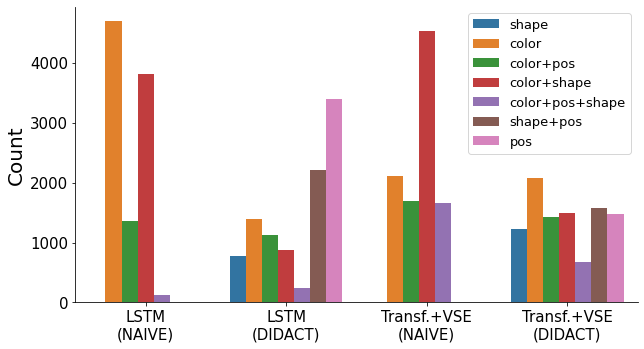

In [17]:
filenames = ["lstm-naive", "lstm-didact","transformer-vse-naive","transformer-vse-didact"]
df = create_model_hists_df(filenames, "data", ignore_unk=True)
create_model_hists_plot_v2(df, legend_cols=4)